# Identify land use from satellite images using Convolutional Neural Networks - Part 1
## *Basic CNN architecture*

In this notebook, you will explore basic Convolutional Neural Network (CNN) architectures by solving a land use identification task, framed as *multilabel image classification*. We will use the *UC Merced Land Use dataset*, a benchmark dataset in the field of Remote Sensing.

After getting to know the dataset, you will start with a guided walkthrough showing how to implement, train and test a CNN architecture in PyTorch. This will include instructions on how to load and normalize the imagery fed to the CNN model.

After the walkthrough, you are asked to explore how changing the model's architecture (e.g., number of convolutional layers, filter sizes, ...) influences the classification performance. Later, you should explore how adjusting the hyperparameters (e.g., learning rate, batch size, and number of training epochs) affects the learning process and model performances.

## Introduction to the UC Merced Land Use Dataset

The UC Merced Land Use dataset is a collection of aerial orthoimagery, annotated to serve as a ground truth for evaluating land-use classification algorithms. Duee to its high-resolution imagery, this dataset allows for detailed analysis and research into urban planning and land management.

### Dataset Composition

The dataset comprises images from **21 distinct land-use classes**, each representing a different type of urban, agricultural, or natural area. These classes include:

|                             |                             |                               |
|-----------------------------|-----------------------------|-------------------------------|
| Agricultural                | Airplane                    | Baseball Diamond              |
| Beach                       | Buildings                   | Chaparral                     |
| Dense Residential           | Forest                      | Freeway                       |
| Golf Course                 | Harbor                      | Intersection                  |
| Medium Density Residential  | Mobile Home Park            | Overpass                      |
| Parking Lot                 | River                       | Runway                        |
| Sparse Residential          | Storage Tanks               | Tennis Court                  |


For each class, 100 images of ~256x256 pixels are provided, making a total of 2100 images in the dataset. These images were handpicked from the USGS National Map Urban Area Imagery collection, covering various urban areas across the United States such as Birmingham, Boston, Buffalo, and many more.

### Imagery and Features

All images are in the RGB colorspace, with a pixel resolution of *one foot* (~30cms), ensuring that details are captured with precision.

Although the term *land-use* is broadly used to describe the dataset's classes, it's important to note that the collection includes land-cover and object classes as well. The diversity in spatial patterns — ranging from homogeneous textures and colors to heterogeneous scenes — provides a rich source of data for exploration.

### Paper and reference

This dataset is specifically designed for research purposes, contributing significantly to the field of remote sensing and machine learning, particularly in land-use classification. The original paper is available [here](https://www.researchgate.net/publication/221589425_Bag-of-visual-words_and_spatial_extensions_for_land-use_classification#fullTextFileContent).

> Yi Yang and Shawn Newsam, "Bag-Of-Visual-Words and Spatial Extensions for Land-Use Classification," ACM SIGSPATIAL International Conference on Advances in Geographic Information Systems (ACM GIS), 2010.

## Data Availability



**All data files** are available for download from SurfDrive. This includes:
1. `Images/` folder with all images --> [here](https://surfdrive.surf.nl/files/index.php/s/SvSQhltknEtQyeY);
2. `labels.csv` file with ID of images in `Images/` and corresponding integer label --> [here](https://surfdrive.surf.nl/files/index.php/s/Bmo3Pf9PMFnDqK8);
3. `label_mapping.txt` text file containing a dictionary to match corresponding integer label to description --> [here](https://surfdrive.surf.nl/files/index.php/s/BNO2kkp4Tw7n2lr).

You need to **upload the data** to your Google Drive and **change the folder paths** below to match the name of your specific folders.

# Walkthrough

## Load modules and connect to Google Drive

In [3]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from torchsummary import summary

from sklearn.model_selection import train_test_split

In [4]:
# Connect to Google Colab
from google.colab import drive

# This will prompt for authorization to access your Google Drive from Colab.
drive.mount('/content/drive', force_remount=True)

# After mounting, you can navigate to a specific folder using the usual UNIX cd command.
# Replace 'your_folder_path' with the actual path of your folder inside Google Drive.
folder_path = '/content/drive/MyDrive/Teaching/DSAIE/UNIT2/CNN/'  # Example path

%cd "$folder_path"

ModuleNotFoundError: No module named 'google'

In [5]:
# Check if CUDA is available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


## Loading and visualizing the UC Merced Land Use Dataset

It is a good practice to start developing a model using a limited *sample size*. After making sure that everything works as expected, one could then scale-up the implementation by training on the full dataset.

In [7]:
# Load CSV file and subsample (sample_size==-1 for full dataset)
sample_size = 200
if sample_size == -1:
  df = pd.read_csv('../data/labels.csv')
else:
  df = pd.read_csv('../data/labels.csv').sample(sample_size)

# Get image file paths and labels
image_paths = df['image'].values
labels = df['label'].values
num_classes = 21 # We specify the max number of classes in the dataset, regardless of the initial subsampling
print(f'Loaded {len(image_paths)} images, with {num_classes} different classes.')

# Load the mapping between integer labels and class names
label_mapping = {}
with open('../data/label_mapping.txt', 'r') as file:
    for line in file:
        value, key = line.strip().split(': ')
        label_mapping[int(key)] = value

print(label_mapping)

Loaded 200 images, with 21 different classes.
{0: 'agricultural', 1: 'airplane', 2: 'baseballdiamond', 3: 'beach', 4: 'buildings', 5: 'chaparral', 6: 'denseresidential', 7: 'forest', 8: 'freeway', 9: 'golfcourse', 10: 'harbor', 11: 'intersection', 12: 'mediumresidential', 13: 'mobilehomepark', 14: 'overpass', 15: 'parkinglot', 16: 'river', 17: 'runway', 18: 'sparseresidential', 19: 'storagetanks', 20: 'tenniscourt'}


Use code below to visualize samples from the original dataset. Are somee classes more difficult to discern than others?

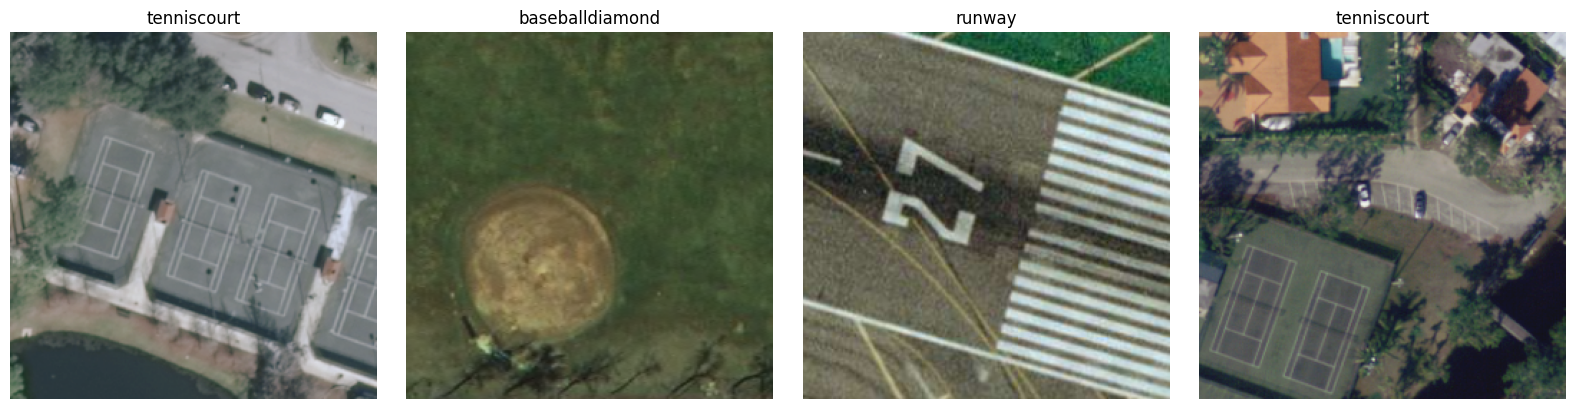

In [9]:
# Sample 4 random images from the dataframe
df_sampled = df.sample(4)

# Plotting
fig, axs = plt.subplots(1, 4, figsize=(16, 4))  # 1 row, 4 columns

for ax, (index, row) in zip(axs, df_sampled.iterrows()):
  with Image.open(f'../data/Images/{row.image}') as img:
    ax.imshow(img)
  ax.set_title(label_mapping[row.label])
  ax.axis('off')  # This will remove the axis and ticks around the image

plt.tight_layout()

## Datasets creation




Before we can begin training our model, we need to prepare and load our dataset properly. Here's an outline of the steps involved in this crucial phase:

1. **Splitting the Dataset**: To evaluate our model effectively, we divide the data into three sets: training, validation, and test. Using the `train_test_split` function, we allocate 70% of the data for training and 15% each for validation and testing. This split ensures that we have distinct datasets for different stages of model evaluation.

2. **Dataset Loading**: From the set of image ids and corresponding labels, we load the related imagery into our computing environment.

3. **Normalization**: It's vital to normalize the images in the training set by computing their mean and standard deviation. This process brings the pixel values into a similar range, enhancing the stability and speed of the training process. We apply these calculated statistics to normalize the validation and test sets as well.

4. **TensorDataset and DataLoaders**:
   - `TensorDataset` wraps tensors representing each image such that each sample will be retrieved by indexing along the first dimension. This allows us to easily combine multiple tensors into a single dataset.
   - `DataLoader` takes a dataset and returns an iterable over the dataset. This is beneficial for batching, shuffling, and loading the data in parallel using multiprocessing workers. `DataLoader` is especially useful when dealing with large datasets that cannot be loaded into memory at once.

5. **Progress Monitoring with tqdm**: In the code, we use `tqdm` when loading images. [`tqdm`](https://tqdm.github.io/docs/tqdm/) is a fast, extensible progress bar for loops and iterable processes in Python. It provides a visual cue to monitor the progress of data loading operations, which can be quite lengthy when dealing with large datasets.

By following these steps, we ensure that our data is not only accurately represented but is also in a format that is optimal for the training process with PyTorch. This setup helps us to focus on building and training the model, rather than worrying about data management.

In [10]:
# Split the data (adjust the test_size according to your needs)
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.30, random_state=42)

val_paths, test_paths, val_labels, test_labels = train_test_split(
    test_paths, test_labels, test_size=0.5, random_state=42)

In [13]:
def load_images(file_paths, transform, folder_path='../data/Images/'):
    images = []
    for file_path in tqdm(file_paths, desc='Loading images'):
        # Load the image
        with Image.open(folder_path+file_path) as img:
            # Convert image to RGB if it's not and apply the same basic transformations
            img = img.convert('RGB')
            img = transform(img)
            images.append(img)
    return torch.stack(images)

def calculate_mean_std(stacked_images):
    # Mean and std are calculated across the height and width dimensions (2 and 3)
    mean = stacked_images.view(stacked_images.size(0), stacked_images.size(1), -1).mean(dim=2).mean(dim=0)
    std = stacked_images.view(stacked_images.size(0), stacked_images.size(1), -1).std(dim=2).mean(dim=0)
    return mean, std

# Basic image transformations to load the training dataset
basic_transform = transforms.Compose([
    transforms.Resize((224, 224), antialias=True),        # 224x224 is a common "historical" format for benchmarking CNNs
    transforms.ToTensor()
])

# Load images for the mean/std calculation
train_images = load_images(train_paths, basic_transform)

# Calculate mean and std
mean, std = calculate_mean_std(train_images)

# Normalize the training dataset
normalize_transform = transforms.Normalize(mean=mean, std=std)

# Apply the normalization to each training image
train_images = torch.stack([normalize_transform(image) for image in train_images])

Loading images: 100%|██████████| 140/140 [00:00<00:00, 475.22it/s]


In [14]:
# Transformation with normalization for validation and test dataset
transform = transforms.Compose([
    transforms.Resize((224, 224), antialias=True),        # 224x224 is a common "historical" format for benchmarking CNNs
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Load and normalize the validation and test datasets
val_images = load_images(val_paths, transform)
test_images = load_images(test_paths, transform)

# Convert labels to tensors
train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)
test_labels = torch.tensor(test_labels)

# Create TensorDatasets
train_dataset = TensorDataset(train_images, train_labels)
val_dataset = TensorDataset(val_images, val_labels)
test_dataset = TensorDataset(test_images, test_labels)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Loading images: 100%|██████████| 30/30 [00:01<00:00, 28.15it/s]


## Defining the CNN architecture with PyTorch
In this section, we'll define our CNN architecture using PyTorch's classes and methods.




![Typical CNN](https://upload.wikimedia.org/wikipedia/commons/6/63/Typical_cnn.png)

### Basic CNN architecture

Here's what you need to know about the structure of the basic CNN we're going to create:

1. **PyTorch Class Structure**: Our CNN is defined as a class `BasicCNN` that inherits from `nn.Module`. The typical PyTorch class has at least two essential functions: `__init__` for initializing the layers and `forward` for specifying the forward pass of the network.

2. **Convolution and Pooling Layers**: Convolutional layers are the core building blocks of a CNN, responsible for extracting features from the input images. Pooling (or subsampling) layers, often following convolutions, reduce the spatial size of the representation, which decreases the number of parameters and computations in the network. By alternating these layers, we create a sequence of "blocks" that process and compress the image information step by step.

3. **Feature Map Reduction**: Throughout the network, the size of the feature maps usually decreases following each convolution, due to either the stride or padding settings, and always decreases after pooling. This systematic reduction concentrates the image information, preparing it for classification.

4. **Flattening and Classification**: After the last convolutional block, we flatten the output to create a single long features vector. This serves as the input to the classifier, a Multilayer Perceptron (MLP), whose complexity depends also on the problem complexity and the dataset size. The job of this classifier is to take the high-level features extracted by the convolutional blocks and make a final prediction.

### Convolution Types
The convolution layer is fundamental for feature extraction. There are two main types of convolutions that determine how the output size is affected by the layer parameters:

- **Same Convolution**: Ensures that the output feature map has the same spatial dimensions as the input feature map. This is achieved by adding padding to the input. The amount of padding is determined based on the kernel size to compensate for the reduction in dimensionality during the convolution operation.

- **Valid Convolution**: No padding is added to the input, and the convolution is only applied where the kernel fits inside the input space. This results in an output feature map that is smaller than the input.


![Convolution types](https://i.stack.imgur.com/7HSXgm.png)
(credits: https://ai.stackexchange.com/)


### 2D Convolutions in PyTorch

When defining a convolutional layer, several arguments are important to understand:

- `in_channels`: The number of channels in the input image. For example, a standard RGB image has 3 channels for the red, green, and blue components.
- `out_channels`: The number of filters (or kernels) that the convolution layer will learn. Each filter extracts different features from the input image, resulting in a distinct output channel.
- `kernel_size`: The size of the filter that is applied to the input image. A kernel size of \(3\) means a \(3 $\times$ 3\) filter is used.
- `stride`: The step size of the filter as it moves across the input image. A stride of \(1\) moves the filter one pixel at a time, while a stride of \(2\) moves it two pixels, and so on.
- `padding`: The number of pixels added to the edges of the input image to preserve spatial dimensions (for 'same' convolution) or to control the spatial size of the output feature map.

By adjusting these parameters, you can control the size of the output feature map and the characteristics of the features extracted by the network.

### Pooling: Max and Average

There are two common types of pooling:

- **Max Pooling**: Takes the maximum value from each patch of the feature map. It's useful for capturing the most prominent feature within the local patch.

- **Average Pooling**: Calculates the average value of each patch, smoothing the feature map and summarizing the presence of features.

Both are typically applied with a 2x2 filter and stride of 2, reducing the size of the feature map by half.

![Pooling types](https://www.researchgate.net/publication/373479024/figure/fig2/AS:11431281184393218@1693318175147/Pooling-operation_W640.jpg )


Also, pay attention to the following aspects in the code below:

* **Pooling Layer Reusability**: Since pooling layers do not have trainable parameters, we can define a single instance and use it multiple times in our architecture, optimizing our code.

* **Determining Layer Input Dimensions**: Figuring out the correct input dimensions for each layer can sometimes be challenging. A practical method to determine these sizes is to insert print statements inside the `forward` method, which reveal the size of the data at each stage of the model.

* **Model Summary**: Lastly, we use `summary` from `torchsummary` to display a summary of our model. It shows the layers, their shapes, and the number of parameters, giving us a clear overview of the architecture and helping to ensure that everything is connected correctly.

With this blueprint, we're ready to instantiate our `BasicCNN` model and prepare it for training. By examining the architecture closely, we can gain a better understanding of how data flows through a CNN and what changes we might want to make for our specific use case.


In [18]:
# Define the CNN architecture
class BasicCNN(nn.Module):
    def __init__(self, num_classes):
        super(BasicCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        # pooling has no learnable parameters, so we can just use one
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # MLP classifier
        self.fc = nn.Linear(128 * 3 * 3, num_classes)

    def forward(self, x):
        # print("Input size:", x.size())
        x = self.pool(F.relu(self.conv1(x)))
        # print("Layer size:", x.size())
        x = self.pool(F.relu(self.conv2(x)))
        # print("Layer size:", x.size())
        x = self.pool(F.relu(self.conv3(x)))
        # print("Layer size:", x.size())
        x = self.pool(F.relu(self.conv4(x)))
        # print("Layer size:", x.size())
        x = self.pool(F.relu(self.conv5(x)))
        # print("Layer size:", x.size())
        x = self.pool(F.relu(self.conv6(x)))
        # print("Layer size:", x.size())
        x = x.view(-1, 128 * 3 * 3)  # Flatten the tensor
        # print("Layer size:", x.size())

        # Fully connected layer for classification
        x = self.fc(x)

        return x

In [19]:
# Instantiate the CNN
model = BasicCNN(num_classes=num_classes).to(device)  # Replace with your model and number of classes
summary(model, input_size=(3, 224, 224))  # Replace with your input size

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
         MaxPool2d-2         [-1, 32, 112, 112]               0
            Conv2d-3         [-1, 64, 112, 112]          18,496
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 128, 56, 56]          73,856
         MaxPool2d-6          [-1, 128, 28, 28]               0
            Conv2d-7          [-1, 128, 28, 28]         147,584
         MaxPool2d-8          [-1, 128, 14, 14]               0
            Conv2d-9          [-1, 128, 14, 14]         147,584
        MaxPool2d-10            [-1, 128, 7, 7]               0
           Conv2d-11            [-1, 128, 7, 7]         147,584
        MaxPool2d-12            [-1, 128, 3, 3]               0
           Linear-13                   [-1, 21]          24,213
Total params: 560,213
Trainable params:

## CNN Training and Validation

### Training loop




Here's a breakdown of the code below performing model training and validation:

1. **PyTorch Training Loop**: The training loop is where the model learns from the dataset. It involves a *forward* pass to compute the outputs and the loss, a *backward* pass to calculate gradients, and an *optimizer* step to update the weights.

2. **CrossEntropyLoss**: We use `nn.CrossEntropyLoss` because it's suitable for multiclass classification problems. The `nn.CrossEntropyLoss` in PyTorch combines softmax and negative log likelihood into one step, streamlining multi-class classification tasks. It takes raw network outputs (logits) and directly computes the loss, preventing errors and simplifying the training process

3. **AdamW Optimizer**: `optim.AdamW` is an extension of the Adam optimizer that includes weight decay for regularization. While Adam is a popular choice due to its adaptiveness in terms of learning rate, AdamW modifies the weight decay component, often leading to better training stability and performance. Other options for optimizers include SGD (Stochastic Gradient Descent), RMSprop, and more.

4. **Validation Inside Training Loop**: We perform validation inside the training loop to monitor the model's performance on a separate set of data that it hasn't seen during training. This helps us to check for overfitting and to understand how well the model generalizes to new data.

5. **Output Metrics**: The output at each epoch shows the training loss, validation loss, and accuracy. *Accuracy* is a common metric for classification tasks, but depending on the problem, other metrics like *F1-score*, *Precision*, *Recall*, or *ROC AUC* might be more appropriate.

6. **Overfitting Control**: In this code, we do not implement any early stopping mechanism. As you know, *early stopping* is a form of regularization used to avoid overfitting by ending training if the validation loss starts to increase. Without it, we have less control over overfitting, which might result in a model that performs well on the training data but poorly on unseen data.

In [26]:
# Define loss function, optimizer and training epochs
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
num_epochs = 20


# Initialize lists to store losses and accuracies
training_losses = []
validation_losses = []
validation_accuracies = []

# We keep track of the best validation accuracy and save the best model
best_val_accuracy = 0.0
best_model_path = '../models/best_model.pth'

# Training loop
for epoch in range(num_epochs):
    model.train()
    training_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        training_loss += loss.item()

    # Store average training loss for the epoch
    training_losses.append(training_loss/len(train_loader))

    # Validation loop
    model.eval()
    validation_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Store average training loss and accuracy for the epoch
    validation_losses.append(validation_loss / len(val_loader))
    val_accuracy = 100 * correct / total
    validation_accuracies.append(val_accuracy)

    # save best model based on validation accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), best_model_path)
        print(f"Epoch {epoch+1}: Improved validation accuracy to {best_val_accuracy:.2f}%. Model saved.")

    print(f'Epoch {epoch+1}/{num_epochs}', f'Train Loss: {training_losses[-1]:.4f}, '
        f'Validation Loss: {validation_losses[-1]:.4f}, '
        f'Accuracy: {validation_accuracies[-1]:.2f}%')

Epoch 1: Improved validation accuracy to 26.67%. Model saved.
Epoch 1/20 Train Loss: 0.4092, Validation Loss: 4.7210, Accuracy: 26.67%
Epoch 2: Improved validation accuracy to 30.00%. Model saved.
Epoch 2/20 Train Loss: 0.3340, Validation Loss: 4.8317, Accuracy: 30.00%
Epoch 3/20 Train Loss: 0.2294, Validation Loss: 5.3365, Accuracy: 30.00%
Epoch 4/20 Train Loss: 0.2640, Validation Loss: 5.3736, Accuracy: 30.00%
Epoch 5/20 Train Loss: 0.1770, Validation Loss: 5.3784, Accuracy: 26.67%
Epoch 6/20 Train Loss: 0.1385, Validation Loss: 5.9052, Accuracy: 30.00%
Epoch 7/20 Train Loss: 0.1136, Validation Loss: 6.2832, Accuracy: 30.00%
Epoch 8: Improved validation accuracy to 33.33%. Model saved.
Epoch 8/20 Train Loss: 0.1390, Validation Loss: 6.6016, Accuracy: 33.33%
Epoch 9/20 Train Loss: 0.0946, Validation Loss: 6.7834, Accuracy: 33.33%
Epoch 10/20 Train Loss: 0.1069, Validation Loss: 7.0499, Accuracy: 30.00%
Epoch 11/20 Train Loss: 0.0735, Validation Loss: 7.4691, Accuracy: 26.67%
Epoch 12/

In [27]:
# Load the best model after training is complete
model.load_state_dict(torch.load(best_model_path))
print("Loaded best model from:", best_model_path)

Loaded best model from: ../models/best_model.pth


### Plotting losses and accuracies

Before plotting losses and accuracies for a better understanding of the training process, we ensure that all training and validation metrics are transferred from the GPU to the CPU before visualization. This is standard practice for compatibility with plotting libraries and other data analysis tools that may not support GPU tensors.

To do this, we use `.cpu().item()` to move each value to the CPU and convert it to a standard Python float. The `if hasattr(loss, 'cpu')` check ensures that this operation is only applied to tensors that are on the GPU, avoiding unnecessary operations for data already on the CPU.

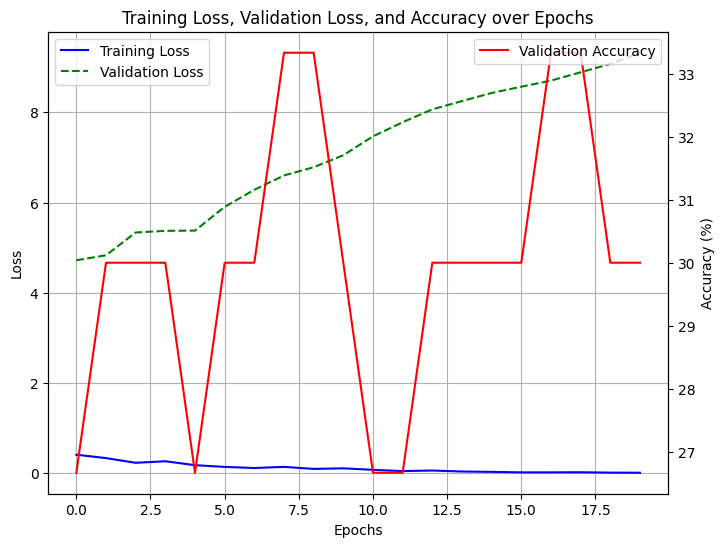

In [28]:
# Move losses and accuracies to CPU for visualization (good practice)
training_losses = [loss.cpu().item() if hasattr(loss, 'cpu') else loss for loss in training_losses]
validation_losses = [loss.cpu().item() if hasattr(loss, 'cpu') else loss for loss in validation_losses]
validation_accuracies = [acc.cpu().item() if hasattr(acc, 'cpu') else acc for acc in validation_accuracies]


# Create a figure and a single set of x-axis labels
fig, ax1 = plt.subplots(1, figsize=(8,6))

# Plot training and validation loss on the same plot with a shared x-axis
epochs = range(1, num_epochs + 1)
ax1.plot(training_losses, 'b-', label='Training Loss')
ax1.plot(validation_losses, 'g--', label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.tick_params(axis='y')
ax1.legend(loc='upper left')

# Instantiate a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
ax2.plot(validation_accuracies, 'r-', label='Validation Accuracy')
ax2.set_ylabel('Accuracy (%)')
ax2.tick_params(axis='y')
ax2.legend(loc='upper right')

# Title and grid
plt.title('Training Loss, Validation Loss, and Accuracy over Epochs')
ax1.grid(True)

## Evaluation on the Test Dataset

In [29]:
# Test loop
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Update progress bar with stats
print(f'Test Loss: {test_loss:.4f}', f'Accuracy: {100 * correct / total:.2f}%')

Test Loss: 8.5288 Accuracy: 40.00%


### Visual comparison of predicted labels vs ground truth

The provided code snippet is designed to visualize a random selection of images from the test dataset and compare the model's predictions against the ground truth labels.

- `denormalize` function: This reverses the normalization process applied during preprocessing, scaling the image data back to the [0, 1] range for proper visualization. Normalization typically involves subtracting a mean value and dividing by a standard deviation for each color channel. Denormalization multiplies by the standard deviation and adds the mean back.

- `get_predictions` function: Retrieves a batch of images and labels from the test DataLoader and uses the trained model to predict the labels. It then selects a random subset of images along with their true and predicted labels for visualization.

- The visualization loop: Plots each of the selected images with titles indicating the predicted and true labels.

Denormalization is necessary because the plotting library (`matplotlib`) expects image data in the [0, 1] range for floats. Without denormalizing, the images would be misrepresented due to the normalization offsets and scales. While we could theoretically use the original images, denormalizing the tensors we've already loaded is more efficient and ensures we're visualizing the exact data the model is making predictions on.


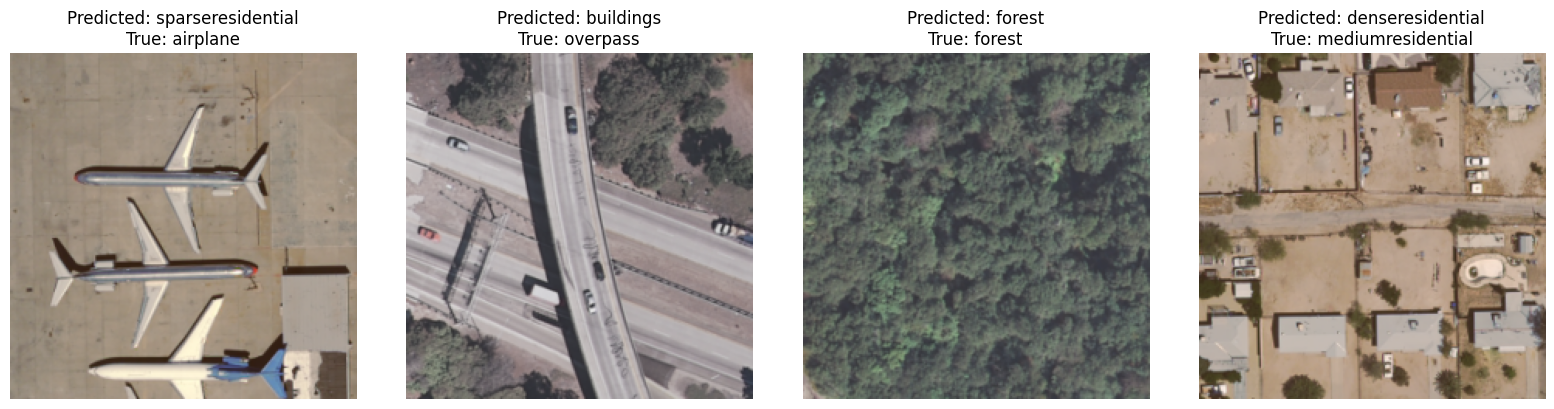

In [30]:
def denormalize(image_tensor, mean, std):
    # Denormalize the image
    denorm_img = image_tensor * std[:, None, None] + mean[:, None, None]
    # Clip values to be between 0 and 1
    denorm_img = denorm_img.clip(0, 1)
    return denorm_img

# Function to get a batch of images and labels, and make predictions
def get_predictions(data_loader, model, num_images):
    model.eval()  # Set the model to evaluation mode
    images, labels = next(iter(data_loader))  # Get a batch from the DataLoader
    outputs = model(images.to(device))  # Get the model outputs
    _, preds = torch.max(outputs, 1)  # Get the index of the max log-probability as the prediction

    # Select random images and labels from the batch
    rand_indices = np.random.choice(images.size(0), num_images, replace=False)
    sample_images = images[rand_indices]
    sample_labels = labels[rand_indices]
    sample_preds = preds[rand_indices]

    return sample_images.cpu(), sample_labels.cpu(), sample_preds.cpu()

# Modify `num_samples` as per requirement
num_samples = 4
sample_images, sample_labels, sample_preds = get_predictions(test_loader, model, num_samples)

# Plotting
fig, axs = plt.subplots(1, num_samples, figsize=(16, 4))  # 1 row, `num_samples` columns

for i in range(num_samples):
    img_tensor = sample_images[i]
    denorm_img = denormalize(img_tensor, mean, std)
    img = denorm_img.numpy().transpose((1, 2, 0))

    label = label_mapping[sample_labels[i].item()]  # Get the ground truth label
    pred = label_mapping[sample_preds[i].item()]  # Get the predicted label

    axs[i].imshow(img)
    axs[i].set_title(f'Predicted: {pred}\nTrue: {label}')
    axs[i].axis('off')  # This will remove the axis and ticks around the image

plt.tight_layout()

# Assignments



In these exercises, you will experiment with architectural changes, adjust main training parameters to observe their effects on performance, and assess performance using different metrics. Finally, you will scale your approach to the full dataset. You should **work in groups** to speed your investigations.

1. **Explore Model Architectures**: Experiment with different CNN architectures to find a more optimal model. Try altering the *number of layers*, changing the *kernel* sizes, experimenting with different types of *pooling*, and observing the effect on performance. Your goal is to find a balance between model size and accuracy, looking for smaller models that maintain accuracy or larger models that significantly increase accuracy.

2. **Tune Training Parameters**: Adjust the main training parameters, such as the optimizer's *learning rate*, the *number of training epochs*, and the *batch size*. Observe how these changes affect the model's training and validation performance. Document your findings and provide insights into the relationship between these parameters and model performance.

3. **Performance metrics**: Evaluate model test performance using more comprehensive metrics than *Accuracy*, such as *Precision*, *Recall*, and *F1-score*. These metrics provide a more detailed picture of model behavior across different classes and error types. Use the confusion matrix to check for common misclassifications (e.g., harbors as parking lots?).

4. **Scale Up to the Full Dataset**: Once you have identified the best setup with the subset of data, re-run the entire notebook using the *full dataset*. Compare the results with those obtained from the smaller subset. Discuss any differences in performance and training time, and explain any steps needed to adjust the model or training process when scaling up.